In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2, os, random
from keras import layers, losses, metrics
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import np_utils, to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# Checking 'train' dataframe
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [4]:
# Checking 'train' descriptive statistics
train.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [5]:
# Looking up general info about the data, such as number of entries, feature names, null values, and Dtype
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


In [6]:
# Checking shape
train.shape

(9912, 14)

In [7]:
images = []
count = 0
for index in range(len(train)):
    Id = train.loc[index, 'Id']
    path = 'data/train/'+str(Id)+'.jpg'
    img_array = cv2.imread(path)
    img_array = resize(img_array, (64, 64), anti_aliasing=True)
    images.append(img_array)
    count += 1
    progress = (count/len(train))*100
    print('progress =', round(progress,2), '%', end='\r')

In [39]:
X = np.array(images).reshape(-1,64,64,3) / 255
X.shape

(9912, 64, 64, 3)

In [40]:
y = train['Pawpularity']
y.shape

(9912,)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
def image_read(path):
    return cv2.imread(path)

train['path'] = train.apply(lambda x : 'data/train/' + x['Id'] + ".jpg", axis=1)

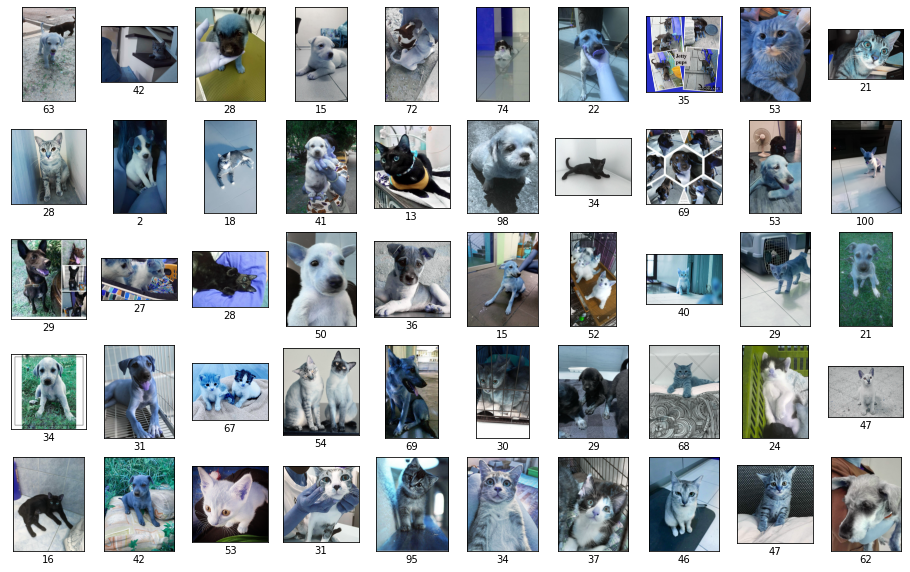

In [11]:
# Plot first 50 images
fig, ax = plt.subplots(5,10,figsize=(16, 10))
for i, (path, score) in enumerate(train[['path', 'Pawpularity']][:50].values.tolist()):
    row, col = i // 10, i % 10
    axis = ax[row][col]
    axis.imshow(image_read(path))
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(score)
plt.show()

## Baseline Artificial Neural Network

In [42]:
ann = Sequential([
        layers.Flatten(input_shape=(64,64,3)),
        layers.Dense(1000, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(10, activation='softmax')
      ])

ann.compile(optimizer='SGD',
            loss=losses.MeanSquaredError(),
            metrics=[metrics.RootMeanSquaredError()])

ann.fit(X_train, y_train, epochs=5)

Epoch 1/5
233/233 [==============================] - 32s 136ms/step - loss: 1860.7437 - root_mean_squared_error: 43.1363
Epoch 2/5
233/233 [==============================] - 23s 97ms/step - loss: 1860.7432 - root_mean_squared_error: 43.1363
Epoch 3/5
233/233 [==============================] - 24s 102ms/step - loss: 1860.7432 - root_mean_squared_error: 43.1363
Epoch 4/5
233/233 [==============================] - 27s 118ms/step - loss: 1860.7438 - root_mean_squared_error: 43.1363
Epoch 5/5
233/233 [==============================] - 24s 103ms/step - loss: 1860.7433 - root_mean_squared_error: 43.1363


In [43]:
cnn1 = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
      ])

cnn1.compile(optimizer='adam',
            loss=losses.MeanSquaredError(),
            metrics=[metrics.RootMeanSquaredError()])

cnn1.fit(X_train, y_train, epochs=10)

Epoch 1/10
233/233 [==============================] - 60s 258ms/step - loss: 1860.7435 - root_mean_squared_error: 43.1363
Epoch 2/10
233/233 [==============================] - 48s 205ms/step - loss: 1860.7438 - root_mean_squared_error: 43.1363
Epoch 3/10
233/233 [==============================] - 58s 250ms/step - loss: 1860.7432 - root_mean_squared_error: 43.1363
Epoch 4/10
233/233 [==============================] - 39s 169ms/step - loss: 1860.7435 - root_mean_squared_error: 43.1363
Epoch 5/10
233/233 [==============================] - 51s 221ms/step - loss: 1860.7432 - root_mean_squared_error: 43.1363
Epoch 6/10
233/233 [==============================] - 48s 208ms/step - loss: 1860.7437 - root_mean_squared_error: 43.1363
Epoch 7/10
233/233 [==============================] - 43s 186ms/step - loss: 1860.7428 - root_mean_squared_error: 43.1363
Epoch 8/10
233/233 [==============================] - 46s 197ms/step - loss: 1860.7439 - root_mean_squared_error: 43.1363
Epoch 9/10
233/233 [====

In [46]:
cnn2 = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(12, activation='relu')
      ])

cnn2.compile(optimizer='adam',
            loss=losses.MeanSquaredError(),
            metrics=[metrics.RootMeanSquaredError()])

cnn2.fit(X_train, y_train, epochs=10)

Epoch 1/10
233/233 [==============================] - 36s 155ms/step - loss: 1198.0096 - root_mean_squared_error: 34.6123
Epoch 2/10
233/233 [==============================] - 41s 175ms/step - loss: 1152.2751 - root_mean_squared_error: 33.9452
Epoch 3/10
233/233 [==============================] - 40s 171ms/step - loss: 1148.7781 - root_mean_squared_error: 33.8936
Epoch 4/10
233/233 [==============================] - 44s 191ms/step - loss: 1151.0189 - root_mean_squared_error: 33.9267
Epoch 5/10
233/233 [==============================] - 43s 184ms/step - loss: 1148.0986 - root_mean_squared_error: 33.8836
Epoch 6/10
233/233 [==============================] - 50s 214ms/step - loss: 1150.7925 - root_mean_squared_error: 33.9233
Epoch 7/10
233/233 [==============================] - 44s 188ms/step - loss: 1149.7682 - root_mean_squared_error: 33.9082
Epoch 8/10
233/233 [==============================] - 55s 237ms/step - loss: 1151.0326 - root_mean_squared_error: 33.9269
Epoch 9/10
233/233 [====

In [48]:
cnn3 = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(12, activation='relu'),
        layers.Dense(1, activation='linear')
      ])

cnn3.compile(optimizer='adam',
            loss=losses.MeanSquaredError(),
            metrics=[metrics.RootMeanSquaredError()])

cnn3.fit(X_train, y_train, epochs=10)

Epoch 1/10
233/233 [==============================] - 76s 326ms/step - loss: 510.1033 - root_mean_squared_error: 22.5855
Epoch 2/10
233/233 [==============================] - 59s 253ms/step - loss: 435.3463 - root_mean_squared_error: 20.8650
Epoch 3/10
233/233 [==============================] - 72s 308ms/step - loss: 436.2269 - root_mean_squared_error: 20.8860
Epoch 4/10
233/233 [==============================] - 57s 245ms/step - loss: 437.9789 - root_mean_squared_error: 20.9279
Epoch 5/10
233/233 [==============================] - 81s 349ms/step - loss: 435.1758 - root_mean_squared_error: 20.8609
Epoch 6/10
233/233 [==============================] - 114s 490ms/step - loss: 432.7637 - root_mean_squared_error: 20.8030
Epoch 7/10
233/233 [==============================] - 71s 305ms/step - loss: 431.8641 - root_mean_squared_error: 20.7813
Epoch 8/10
233/233 [==============================] - 62s 266ms/step - loss: 434.1992 - root_mean_squared_error: 20.8374
Epoch 9/10
233/233 [===========

In [49]:
cnn3.evaluate(X_test, y_test)

78/78 [==============================] - 5s 65ms/step - loss: 438.4290 - root_mean_squared_error: 20.9387


[438.4289855957031, 20.938695907592773]

In [57]:
cnn4 = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(12, activation='relu'),
        layers.Dense(1, activation='linear'),
        layers.Dropout(0.5)
      ])

cnn4.compile(optimizer='adam',
            loss=losses.MeanSquaredError(),
            metrics=[metrics.RootMeanSquaredError()])

cnn4.fit(X_train, y_train, epochs=10)

Epoch 1/10
233/233 [==============================] - 59s 253ms/step - loss: 1220.7703 - root_mean_squared_error: 34.9395
Epoch 2/10
233/233 [==============================] - 77s 331ms/step - loss: 1138.4432 - root_mean_squared_error: 33.7408
Epoch 3/10
233/233 [==============================] - 71s 305ms/step - loss: 1145.7401 - root_mean_squared_error: 33.8488
Epoch 4/10
233/233 [==============================] - 51s 218ms/step - loss: 1149.4653 - root_mean_squared_error: 33.9038
Epoch 5/10
233/233 [==============================] - 86s 370ms/step - loss: 1155.5914 - root_mean_squared_error: 33.9940
Epoch 6/10
233/233 [==============================] - 65s 280ms/step - loss: 1164.2808 - root_mean_squared_error: 34.1216
Epoch 7/10
233/233 [==============================] - 58s 250ms/step - loss: 1150.5096 - root_mean_squared_error: 33.9192
Epoch 8/10
233/233 [==============================] - 80s 345ms/step - loss: 1153.9135 - root_mean_squared_error: 33.9693
Epoch 9/10
233/233 [====

In [59]:
cnn5 = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(12, activation='relu'),
        layers.Dense(1, activation='linear')
      ])

cnn5.compile(optimizer='adam',
            loss=losses.MeanSquaredError(),
            metrics=[metrics.RootMeanSquaredError()])

cnn5.fit(X_train, y_train, epochs=50)

Epoch 1/50
233/233 [==============================] - 66s 282ms/step - loss: 495.1608 - root_mean_squared_error: 22.2522
Epoch 2/50
233/233 [==============================] - 72s 309ms/step - loss: 436.3782 - root_mean_squared_error: 20.8897
Epoch 3/50
233/233 [==============================] - 62s 267ms/step - loss: 440.7486 - root_mean_squared_error: 20.9940
Epoch 4/50
233/233 [==============================] - 55s 236ms/step - loss: 433.5705 - root_mean_squared_error: 20.8224
Epoch 5/50
233/233 [==============================] - 57s 246ms/step - loss: 435.4518 - root_mean_squared_error: 20.8675
Epoch 6/50
233/233 [==============================] - 55s 237ms/step - loss: 428.5671 - root_mean_squared_error: 20.7019
Epoch 7/50
233/233 [==============================] - 62s 268ms/step - loss: 428.0871 - root_mean_squared_error: 20.6903
Epoch 8/50
233/233 [==============================] - 83s 358ms/step - loss: 429.9508 - root_mean_squared_error: 20.7353
Epoch 9/50
233/233 [============

In [71]:
cnn6 = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='relu')
      ])

cnn6.compile(optimizer='adam',
             loss=losses.MeanSquaredError(),
             metrics=[metrics.RootMeanSquaredError()])

cnn6.fit(X_train, y_train, epochs=5)

Epoch 1/5
233/233 [==============================] - 20s 84ms/step - loss: 709.0515 - root_mean_squared_error: 26.6280
Epoch 2/5
233/233 [==============================] - 19s 82ms/step - loss: 427.0473 - root_mean_squared_error: 20.6651
Epoch 3/5
233/233 [==============================] - 19s 83ms/step - loss: 430.3185 - root_mean_squared_error: 20.7441
Epoch 4/5
233/233 [==============================] - 23s 99ms/step - loss: 431.3210 - root_mean_squared_error: 20.7683
Epoch 5/5
233/233 [==============================] - 26s 113ms/step - loss: 429.0798 - root_mean_squared_error: 20.7142
